# Data Exploration 

In [44]:
import pandas as pd
import time
import os
import operator
import sys

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import numpy as np
import matplotlib.pyplot as plt

from afinn import Afinn
from src.load_data import get_data_sem_eval, get_data_sent_140
from src.load_embeddings import read_embeddings_file

from unidecode import unidecode
from tqdm import tqdm
from keras.preprocessing.text import Tokenizer
from sklearn.utils import shuffle
from collections import Counter
import seaborn as sns

In [8]:
embedding_index = read_embeddings_file('../data/glove.twitter.27B/glove.twitter.27B.200d.txt', 'GLOVE')
sent_140 = get_data_sent_140('../data/training.1600000.processed.noemoticon.csv', dataset_size=500000)
sem_eval = get_data_sem_eval('../data/full_dataset/')

Reading GLOVE file...


1193514it [01:18, 15110.91it/s]


positive    800000
negative    800000
Name: class, dtype: int64
neutral     22211
positive    19625
negative     7732
Name: class, dtype: int64


In [9]:
sent_140.head()

,class,id,date,query,user,text
1484659,positive,2067720728,Sun Jun 07 12:50:31 PDT 2009,NO_QUERY,PrincessRonald,"@alliYu I should have! I want Asian food, make..."
587388,negative,2216298099,Wed Jun 17 19:17:54 PDT 2009,NO_QUERY,Wiens111,@nonsanaementis Just re-read the CNN article p...
1230452,positive,1991568748,Mon Jun 01 07:16:33 PDT 2009,NO_QUERY,LostInTweets,Taking a break from moving to eat and watch Th...
3847,negative,1468687248,Tue Apr 07 03:10:10 PDT 2009,NO_QUERY,PixieFlute,@BeththePQ your blog won't let me comment agai...
1244126,positive,1994725942,Mon Jun 01 12:21:42 PDT 2009,NO_QUERY,LoveCarmen,Omg this apple pie lara bar is the best tastin...


In [10]:
sem_eval.head()

,class,text
id,,
619950566786113536,neutral,"Picturehouse's, Pink Floyd's, 'Roger Waters: T..."
619969366986235905,neutral,Order Go Set a Watchman in store or through ou...
619971047195045888,negative,If these runway renovations at the airport pre...
619974445185302528,neutral,If you could ask an onstage interview question...
619987808317407232,positive,A portion of book sales from our Harper Lee/Go...


# Text Preprocessor Development

In [11]:
from ftfy import fix_text
import re

FLAGS = re.MULTILINE | re.DOTALL

REGEX_LOOKUP = {
    "DATE": "(?:(?:(?:(?:(?<!:)\\b\\'?\\d{1,4},? ?)?\\b(?:[Jj]an(?:uary)?|[Ff]eb(?:ruary)?|[Mm]ar(?:ch)?|[Aa]pr(?:il)?|May|[Jj]un(?:e)?|[Jj]ul(?:y)?|[Aa]ug(?:ust)?|[Ss]ept?(?:ember)?|[Oo]ct(?:ober)?|[Nn]ov(?:ember)?|[Dd]ec(?:ember)?)\\b(?:(?:,? ?\\'?)?\\d{1,4}(?:st|nd|rd|n?th)?\\b(?:[,\\/]? ?\\'?\\d{2,4}[a-zA-Z]*)?(?: ?- ?\\d{2,4}[a-zA-Z]*)?(?!:\\d{1,4})\\b))|(?:(?:(?<!:)\\b\\'?\\d{1,4},? ?)\\b(?:[Jj]an(?:uary)?|[Ff]eb(?:ruary)?|[Mm]ar(?:ch)?|[Aa]pr(?:il)?|May|[Jj]un(?:e)?|[Jj]ul(?:y)?|[Aa]ug(?:ust)?|[Ss]ept?(?:ember)?|[Oo]ct(?:ober)?|[Nn]ov(?:ember)?|[Dd]ec(?:ember)?)\\b(?:(?:,? ?\\'?)?\\d{1,4}(?:st|nd|rd|n?th)?\\b(?:[,\\/]? ?\\'?\\d{2,4}[a-zA-Z]*)?(?: ?- ?\\d{2,4}[a-zA-Z]*)?(?!:\\d{1,4})\\b)?))|(?:\\b(?<!\\d\\.)(?:(?:(?:[0123]?[0-9][\\.\\-\\/])?[0123]?[0-9][\\.\\-\\/][12][0-9]{3})|(?:[0123]?[0-9][\\.\\-\\/][0123]?[0-9][\\.\\-\\/][12]?[0-9]{2,3}))(?!\\.\\d)\\b))",
    "EMAIL": "(?:^|(?<=[^\\w@.)]))(?:[\\w+-](?:\\.(?!\\.))?)*?[\\w+-]@(?:\\w-?)*?\\w+(?:\\.(?:[a-z]{2,})){1,3}(?:$|(?=\\b))",
    "EMOJI": "[\uD83C-\uDBFF\uDC00-\uDFFF]+",
    "IP": "\d{1,3}\.\d{1,3}\.\d{1,3}\.\d{1,3}",
    "TIME": "(?:(?:\d+)?\.?\d+(?:AM|PM|am|pm|a\.m\.|p\.m\.))|(?:(?:[0-2]?[0-9]|[2][0-3]):(?:[0-5][0-9])(?::(?:[0-5][0-9]))?(?: ?(?:AM|PM|am|pm|a\.m\.|p\.m\.))?)",
    "MONEY": "(?:[$€£¢]\d+(?:[\.,']\d+)?(?:[MmKkBb](?:n|(?:il(?:lion)?))?)?)|(?:\d+(?:[\.,']\d+)?[$€£¢])",
    "URL": "http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+",
    "NUMBERS": "[-+]?[.\d]*[\d]+[:,.\d]*",
    "PERCENT": "(\d+.)*\d+\s{0,1}%",
    "SCORES" : "\d+\s*-\s*\d+"
}


# Preprocessing Regex's
url_regex = re.compile(REGEX_LOOKUP['URL'])
ip_regex = re.compile(REGEX_LOOKUP['IP'])
date_regex = re.compile(REGEX_LOOKUP['DATE'])
emoji_regex = re.compile(REGEX_LOOKUP['EMOJI'])
email_regex = re.compile(REGEX_LOOKUP['EMAIL'])
time_regex = re.compile(REGEX_LOOKUP['TIME'])
money_regex = re.compile(REGEX_LOOKUP['MONEY'])
numbers_regex = re.compile(REGEX_LOOKUP['NUMBERS'])
percent_regex = re.compile(REGEX_LOOKUP['PERCENT'])
scores_regex = re.compile(REGEX_LOOKUP['SCORES'])

control_chars = re.compile('[\n\t\r\v\f\0]')

parenthesis_regex = re.compile('([\[\]()])')
hearts_regex = re.compile(r'(♥)|(<3{1,})')
users_regex = re.compile("@\w+")
tokenize_punct = re.compile(r'([.,?!"]{1})')
repeated_punct = re.compile('([!?.]){2,}')
elongated_words = re.compile(r"\b(\S*?)(.)\2{2,}\b")
word_split = re.compile(r'[/\-_\\]')
all_caps_regex = re.compile(r'([A-Z]){2,}')
emphasis_regex = re.compile('(\*)(?:\w+ ?){1,}(\*)')
hashtag_regex = re.compile("#\S+")
mentions_regex = re.compile('(?<=^|(?<=[^a-zA-Z0-9-_.]))@([A-Za-z_]+[A-Za-z0-9_]+)')

# seperates things like the'
seperate_apostrophes = re.compile("(\w+)('\w*)")
# seperates things like 'the
seperate_errant_apostrophes = re.compile("(')(([A-zA-Z]){3,})")

def allcaps(text):
    text = text.group()
    return text.lower() + " <allcaps> "


def hashtag(text):
    text = text.group()
    hashtag_body = text[1:]
    if hashtag_body.isupper():
        result = " <hashtag> {} <allcaps> ".format(hashtag_body)
    else:
        test_regex = re.compile(r'((?<=[a-z])[A-Z]|[A-Z](?=[a-z]))')
        hashtag_body = test_regex.sub(r' \1', hashtag_body)
        result = " ".join([" <hashtag>"] + hashtag_body.split(r"(?=[A-Z])") + ["</hashtag> "])
    return result

def emphasis(text):
    text = text.group()
    emph_body = text[1:-1]
    result = " ".join(["<emphasis>"] + emph_body.split(r"(?=[A-Z])") + ["</emphasis>"])
    return result

class TextPreProcessor:
    def __init__(self, embedding_profile=None):
        self.embedding_profile = embedding_profile

    def preprocess(self, string):
        string = self.clean(string)
        return string
    
    def unpack_contractions(self, text):
        """
        Replace *English* contractions in ``text`` str with their unshortened forms.
        N.B. The "'d" and "'s" forms are ambiguous (had/would, is/has/possessive),
        so are left as-is.
        ---------
        Important Note: The function is taken from textacy (https://github.com/chartbeat-labs/textacy).
        """
        text = re.sub(
            r"(\b)([Aa]re|[Cc]ould|[Dd]id|[Dd]are||[Dd]oes|[Dd]o|[Hh]ad|[Hh]as|[Hh]ave|[Ii]s|[Mm]ay|[Mm]ight|[Mm]ust|[Ss]hould|[Ww]as|[Ww]ere|[Ww]ould|[Nn]eed)n't",
            r"\1\2 not", text)
        text = re.sub(
            r"(\b)([Hh]e|[Hh]ow|[Ii]|[Ss]he|[Tt]hat|[Tt]hey|[Ww]e|[Ww]hat|[Ww]ho|[Yy]ou)'ll",
            r"\1\2 will", text)
        text = re.sub(r"(\b)([Tt]hat|[Tt]hey|[Hh]ow|[Ww]e|[Ww]hat|[Ww]ho|[Yy]ou)'re", r"\1\2 are",
                      text)
        text = re.sub(
            r"(\b)([Ii]|[Cc]ould|[Ss]hould|[Tt]hey|[Ww]e|[Ww]hat|[Ww]ho|[Ww]ould|[Yy]ou|[Mm]ight|[Mm]ust|[Mm]ay)'ve",
            r"\1\2 have", text)
        # non-standard
        text = re.sub(r"(\b)([Cc]a)n't", r"\1\2n not", text)
        text = re.sub(r"(\b)([Ii])'m", r"\1\2 am", text)
        text = re.sub(r"(\b)([Ll]et)'s", r"\1\2 us", text)
        text = re.sub(r"(\b)([Ww])on't", r"\1\2ill not", text)
        text = re.sub(r"(\b)([Ss])han't", r"\1\2hall not", text)
        text = re.sub(r"(\b)([Yy])(?:'all|a'll)", r"\1\2ou all", text)
        text = re.sub(r"(\b)([Cc])'[Mm]on", r"\1\2ome on", text)
        text = re.sub(r"(\b)([Ww])/", "with", text)
        text = re.sub(r"(\b)([Ww])/([Oo])", "without", text)
        text = re.sub(r"(\b)([Hh])rs", "hours", text)
        text = re.sub(r"(\b)([Mm])ins", "minutes", text)
        text = re.sub(r"(\b)([Pp])ls", "please", text)
        
        # Add a space around 's, 'd due to enable word vectors to be used.         
        text = re.sub(r"(\w+)'s", r" \1 's", text)
        text = re.sub(r"(\w+)'d", r" \1 'd", text)
        
        return text
    
    def unpack_placements(self, text):
        text = re.sub(r'1[sS][tT]', 'first', text)
        text = re.sub(r'2[nN][dD]', 'second', text)
        text = re.sub(r'3[rR][dD]', 'third', text)
        text = re.sub(r'4[tT][hH]', 'fourth', text)
        text = re.sub(r'5[tT][hH]', 'fifth', text)
        text = re.sub(r'6[tT][hH]', 'sixth', text)
        text = re.sub(r'7[tT][hH]', 'seventh', text)
        text = re.sub(r'8[tT][hH]', 'eigth', text)
        text = re.sub(r'9[tT][hH]', 'ninth', text)
        text = re.sub(r'10[tT][hH]', 'tenth', text)
        
        return text
    
    def replace_smileys(self, text):
        def re_sub(pattern, repl):
            return re.sub(pattern, repl, text, flags=FLAGS)
        loleyes = r"[8:=;]"
        eyes = r"[8:=;Xx]"
        nose = r"['`^\-0Oo]?"
        
        text = re_sub(r"\B{}{}[)dD>]+|\b[<(dD]+{}{}".format(eyes, nose, nose, eyes), ' <smile> ')
        text = re_sub(r"\B{}{}[pPbB]+".format(loleyes, nose), ' <lolface> ')
        text = re_sub(r"\B{}{}[(?]+|\)+{}{}".format(eyes, nose, nose, eyes), ' <sadface> ')
        text = re_sub(r"\B{}{}[\/\\|l]".format(eyes, nose), ' <neutralface> ')
        text = re_sub(r"\B{}{}[*]".format(eyes, nose), ' <kisses> ')
        
        # Replace kisses e.g. xx, xoxoxo
        text = re.sub(r'(\b([Xx][Oo]){1,}\b)|(\b[Xx]{2,}\b)|(\b[Xx]$)', ' <kisses> ', text)

        return text

    def clean(self, text):
        # Fix unicode characters         
        text = fix_text(text)
        text = unidecode(text)
        
        # Replace newline and other control characters
        text = control_chars.sub(' ', text)
        # Replace ips
        text = ip_regex.sub(' <ip> ', text)
        # Replace URLs
        text = url_regex.sub(' <url> ', text)
        # Replace Emails
        text = email_regex.sub(' <email> ', text)
        # Replace User Names
        text = users_regex.sub(' <user> ', text)
        # Replace Dates/Time
        text = date_regex.sub(' <date> ', text)
        text = time_regex.sub(' <time> ', text)
        # Replace abstract number values with an annotation
        text = money_regex.sub(' <currency> ', text)
        text = percent_regex.sub(' <percent> ', text)
        # Replaces simple sport scores etc.
        text=  scores_regex.sub(' <score> ', text)
        
        # Unpack can't -> can not, c'mon -> come on
        text = self.unpack_contractions(text)
        # 1st, 2nd, 3rd  -> First, Second, Third. Performed post-date annotation so we don't remove any useful details
        text = self.unpack_placements(text)
        # Replace various different smileys with a common annotation.
        text = self.replace_smileys(text)
        
        # Split words 
        text = word_split.sub(' ', text)
        
        # Add in wraparound annotations which surround text
        # Introduce a space before hash symbols to prevent issues where hastags are next to each other
        # e.g. #test#chicken
        text = re.sub(r'#', ' #', text)
        text = hashtag_regex.sub(hashtag, text)
#         text = emphasis_regex.sub(emphasis, text)
        
        
        # Replace <3 (less than three) with the more meaningful <heart> annotation         
        text = hearts_regex.sub(' <heart> ', text)
        # Replace Numbers
        text = numbers_regex.sub(' <number> ', text)
        # Add spaces around parenthesis.
        text = parenthesis_regex.sub(r' \1 ', text)
        # Remove multi spaces - Prevents errant <repeat> signals appearing in text
        text = re.sub('\s+', ' ', text)
        # Add in repeat annotation         
        text = repeated_punct.sub(r' \1 <repeat> ', text)
        
        text = tokenize_punct.sub(r' \1 ', text)
        # Add in annotations for all-caps and elongated words  
        text = all_caps_regex.sub(allcaps, text)
        text = elongated_words.sub(r"\1\2 <elong> ", text)
        
        # Expand out common text symbols         
        text = text.replace('&', ' and ')
        text = text.replace('@', ' at ')
        text = seperate_apostrophes.sub(r' \1 \2 ', text)
        text = seperate_errant_apostrophes.sub(r' \1 \2 ', text)
        # Remove a load of unicode emoji characters
        text = emoji_regex.sub('', text)

        # Remove multi spaces
        text = re.sub('\s+', ' ', text)
        # Remove ending space if any
        if len(text) > 1:
            text = re.sub('\s+$', '', text)

        # If this string is a single space replace with an <empty> tag.
        if text == ' ':
            text = '<EMPTY>'

        return text.strip().lower()
    
def tokenize(text):
        # Different regex parts for smiley faces
        eyes = r"[8:=;]"
        nose = r"['`\-^]?"

        # function so code less repetitive
        def re_sub(pattern, repl):
            return re.sub(pattern, repl, text, flags=FLAGS)

        text = re_sub(r"https?:\/\/\S+\b|www\.(\w+\.)+\S*", "<url>")
        text = re_sub(r"{}{}[)dD]+|[)dD]+{}{}".format(eyes, nose, nose, eyes), "<smile>")
        text = re_sub(r"{}{}p+".format(eyes, nose), "<lolface>")
        text = re_sub(r"{}{}\(+|\)+{}{}".format(eyes, nose, nose, eyes), "<sadface>")
        text = re_sub(r"{}{}[\/\\|l*]".format(eyes, nose), "<neutralface>")
        text = re_sub(r"/", " / ")
        text = re_sub(r"@\w+", "<user>")
        text = re_sub(r"<3", "<heart>")
        text = re_sub(r"[-+]?[.\d]*[\d]+[:,.\d]*", "<number>")
        text = re_sub(r"#\S+", hashtag)
        text = re_sub(r"([!?.]){2,}", r"\1 <repeat>")
        text = re_sub(r"\b(\S*?)(.)\2{2,}\b", r"\1\2 <elong>")

        text = mentions_regex.sub('<mention>', text)
        text = re_sub(r"([A-Z]){2,}", allcaps)

        return text.lower()

In [12]:
preprocessor = TextPreProcessor()

In [33]:
text_sample = sem_eval.sample(n=1).iloc[0]['text']

print('Original: ' + text_sample +'\n')
print('Processed Old: ' + tokenize(text_sample) +'\n')
print('Processed New: ' + preprocessor.preprocess(text_sample) +'\n')

Original: Everyone come the the volleyball game at East tomorrow before the football game! #playoffs2012

Processed Old: everyone come the the volleyball game at east tomorrow before the football game!  <hashtag> playoffs<number> </hashtag> 

Processed New: everyone come the the volleyball game at east tomorrow before the football game ! <hashtag> playoffs <number> </hashtag>



# Sequence Length Estimation

In [63]:
def process(df):
    df_copy = df.copy()

    for index, tweet in tqdm(df_copy.iterrows()):
        try:
            start_time = time.time()
            tweet['text'] = preprocessor.preprocess(tweet['text'])
            if (time.time() - start_time) > 5.0:
                print(tweet['id'])

        except:
            pass
    return df_copy

In [470]:
sem_eval['text_len'] = process(sem_eval)['text'].apply(lambda x: len(x.split()))
sem_eval.head()

49568it [00:29, 1686.12it/s]


,class,text,text_len
id,,,
619950566786113536,neutral,"Picturehouse's, Pink Floyd's, 'Roger Waters: T...",29
619969366986235905,neutral,Order Go Set a Watchman in store or through ou...,25
619971047195045888,negative,If these runway renovations at the airport pre...,24
619974445185302528,neutral,If you could ask an onstage interview question...,19
619987808317407232,positive,A portion of book sales from our Harper Lee/Go...,30


In [ ]:
sent_140['text_len'] = process(sent_140)['text'].apply(lambda x: len(x.split()))
sent_140.head()

In [ ]:
sem_eval['text_len'].value_counts()

In [ ]:
sent_140['text_len'].value_counts()

# OOV's

In [64]:
MAX_FEATS = 200000

oov_df = process(sem_eval)

tokenizer = Tokenizer(num_words=MAX_FEATS, filters='"%()*+,-.:;=[\]^_`{|}~')
tokenizer.fit_on_texts(oov_df['text'])

49568it [00:27, 1801.82it/s]


In [65]:
def calc_stats(df, embeddings_index):
    stats = {}
    oovs = {}
    
    filter_set = {'%', '(', ')', '*', '+',',', '-', '.', ':', ';', '=', '[', '\\',']','^','_','`','{','|','}','~','"'}
    
    for index, tweet in tqdm(df.iterrows()):
        splitted = tweet['text'].split()
        for word in splitted:
            word = re.sub('["%()*+,-.:;=[\]^_`{|}~]', '', word)
            
#             if word not in :
            stats[word] = stats.get(word, 0) + 1 
            embedding_vector = embeddings_index.get(word)
            if embedding_vector is None:
                oovs[word] = oovs.get(word, 0) + 1
                
    return stats, oovs

def get_oovs(embeddings_index, word_index):
    oovs = []
    
    stats = {}
    
    for word, i in tqdm(word_index.items()):
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            # words not found in embedding index will be all-zeros.
            continue
        else:
            stats[word] = stats.get(word, 0) + 1
            oovs.append(word)
    return oovs

In [66]:
oovs = get_oovs(embedding_index, tokenizer.word_index)

100%|████████████████████████████████████████████████████████████████████████| 40692/40692 [00:00<00:00, 924539.52it/s]


In [356]:
stats, oov_stats = calc_stats(oov_df, embedding_index)

49568it [00:05, 9852.65it/s] 


In [357]:
print('Number of words: {}'.format(len(tokenizer.word_index)))
print('OOVs: {}'.format(len(oovs)))

Number of words: 40770
OOVs: 5971


In [86]:
re.sub(r"(')(([A-zA-Z]){3,})", r' \1 \2 ', "it's")

"it's"

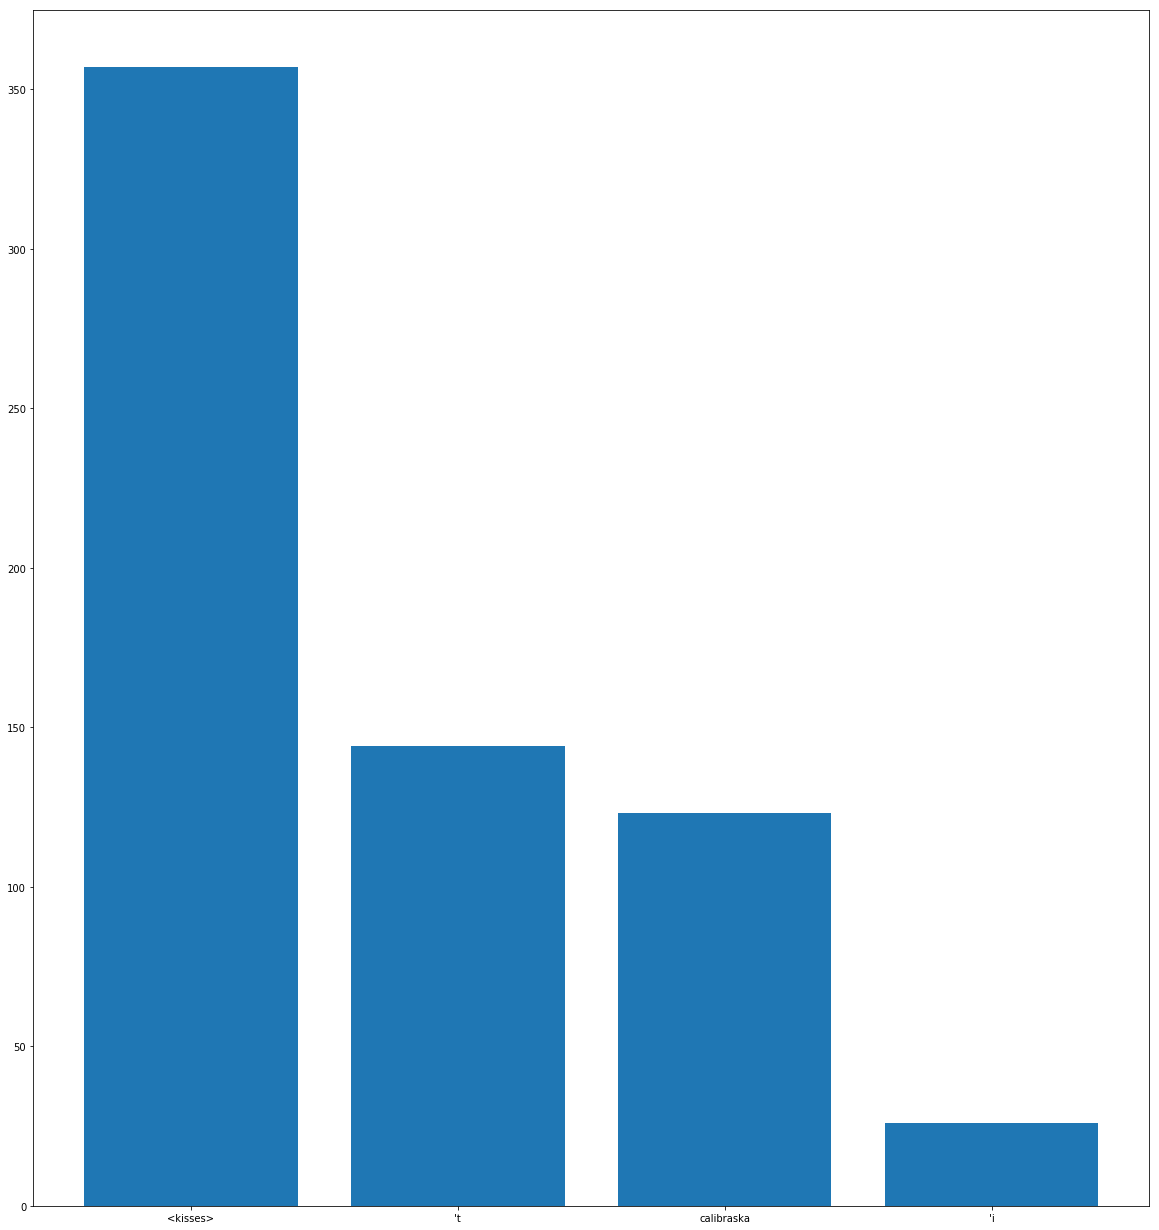

In [443]:
graph_dict = oov_stats

top_oovs = dict(sorted(graph_dict.items(), key=operator.itemgetter(1), reverse=True)[1:5])
plt.figure(figsize=(20,22))
plt.bar(range(len(top_oovs)), top_oovs.values(), align='center')
plt.xticks(range(len(top_oovs)), top_oovs.keys())

plt.show()

In [444]:
print(oovs)

['<kisses>', "'t", 'calibraska', "'i", 'boruto', 'swachh', 'nekromantix', 'kozol', 'fairplex', 'sollee', 'pavol', 'demitra', 'lechlade', 'asiata', 'circoloco', 'vernau', 'haltwhistle', 'knollwood', 'runrig', 'summersville', '$$$', 'yushin', 'seavey', 'a$ap', 'deflategate', 'byrdak', 'khader', 'petrolia', 'bellusci', 'cashee', 'northglenn', 'deniesse', 'gampel', 'henryville', 'bhilwara', '>>>', 'degrom', 'bloodborne', 'seaholm', 'brentley', 'cofield', 'alsip', 'arsht', 'liacouras', 'footymad', 'runako', 'timmonsville', "'l", 'lvms', 'volstead', 'mcquarrie', 'lavalantula', '$$', 'wead', 'lllink', 'badotweet', "'a", "'if", 'trayce', 'refugeecrisis', 'pricewise', 'ghoncheh', 'ghavami', 'bifurcated', 'biform', 'titlefor', '>>>>', 'fifthird', 'topdawgent', 'gsaw', 'ylianna', 'bajrangi', 'schwarber', "'do", 'grichuk', 'distich', 'connotative', 'jivatma', 'monthswithoutzayn', "'we", 'intuc', 'aacta', 'tpab', '<<<', 'kimoji', 'cnis', 'ipoop', 'a$$', 'jerricho', "'or", 'burdwan', 'amiibo', 'varo

# Features

In [4]:
feature_df = sem_eval.copy()

In [36]:
def create_polarity_dict():
    words = Afinn(emoticons=True)
    emoticon_lookup_dict = words._dict
    
    # Emojis are replaced with annotiations e.g. :) -> <smile> and :D -> <smile> perform the same process on the afinn keys
    emoji_keys = [':)', ':(', ':|', ':]', ':[', ':}', ':{', ':/', ':\\', ':*', ':-)', ':-(', ':-|', ':-]', ':-[', ':-}', ':-?', ':->', ':-*', ':-D', ':-P', ':-S', ':-p', ':-/', ':D', ':P', ':S', ':p', ':o)', ":'(", '(:', '):', '(-:', ')-:', ';-(', ';)', ';(', ';-)', ';-D', '=(', '=/', '=\\', '=^/', '=P', '\\o/', '♥', ':-))', ':-)))', ':-))))', ':-)))))', ':-))))))', ':-)))))))', ':-))))))))', ':-)))))))))', '://', ':))', ':)))', ':))))', ':)))))', ':))))))', ':)))))))', ':))))))))', ':)))))))))', ':))))))))))', ':-((', ':-(((', ':-((((', ':((', ';))', ';)))', '<3', '<33', '<333', '<3333', '<33333', '<333333', '<3333333', '<33333333', '<333333333', '8(', '8)', '8-D', '8-)', '8-(', 'X-D', 'x-D']
    emoji_type_lookup = {}

    for key in emoji_keys:
        val = preprocessor.replace_smileys(key).split()[0].strip()

        if val == key:
            val = hearts_regex.sub('<heart>', key)

        if not val == key:
            emoji_type_lookup[key] = val


    annotation_counts = Counter(emoji_type_lookup.values())
    annotation_polarity = {}

    for key in emoji_type_lookup:
        annotation = emoji_type_lookup[key]
        annotation_polarity[annotation] = annotation_polarity.get(annotation, 0) + words.score(key)

    for key in annotation_polarity:
        annotation_polarity[key] /= annotation_counts[key]
    # Create a fresh afinn scorer
    words = Afinn()
    # Grab the thing we care about
    polarity_dict = words._dict
    
    # Add our annotation polarity scores to the afinn dict.
    for key in annotation_polarity:
        polarity_dict[key] = annotation_polarity[key]
    
    return polarity_dict

def safe_div(x, y):
    return x / y if y else 0

def create_sentiment_features(text, polarity_dict):
    score = 0
    positive_score = 0
    positive_count = 0
    negative_score = 0
    negative_count = 0
    # For computing sentiment ranges.   
    positive_max = 0
    negative_max = 0
       
    for word in text.split():
        # Remove characters also removed by the tokenizer
        word = re.sub('["%()*+,-.:;=[\]^_`{|}~]', '', word)
        
        if word in polarity_dict:
            word_score = polarity_dict[word]
            
            if word_score > 0:
                positive_score += word_score
                positive_count += 1
                if word_score > positive_max:
                    positive_max = word_score
                    
            elif word_score < 0:
                negative_score += word_score
                negative_count += 1
                if word_score > negative_max:
                    negative_max = word_score
                
            score += word_score
            

    tweet_average = safe_div((positive_score + negative_score), (positive_count + negative_count))
    average_positivity = safe_div(positive_score, positive_count)
    average_negativity = safe_div(negative_score, negative_count)
    sentiment_range = average_positivity - average_negativity
    positive_range = positive_max - tweet_average
    negative_range = negative_max - tweet_average
    
    return tweet_average, average_positivity, average_negativity, sentiment_range, positive_range, negative_range
    
    

In [37]:
polarity = create_polarity_dict()

def create_features(df, polarity_dict):
    rows = []
    for index, tweet in tqdm(df.iterrows()):
        
        tweet['orig_text'] = tweet['text']
        tweet['text'] = preprocessor.preprocess(tweet['text'])
        
        average_sent, average_pos, average_neg, sent_range, pos_range, neg_range = create_sentiment_features(tweet['text'], polarity_dict)
        
        tweet['average_sentiment'] = average_sent
        tweet['average_positivity'] = average_pos
        tweet['average_negativity'] = average_neg
        tweet['sentiment_range'] = sent_range
        tweet['positivity_range'] = pos_range
        tweet['negativity_range'] = neg_range
        rows.append(tweet)
        
    return pd.DataFrame(rows)
    
feature_df = create_features(feature_df, polarity)

49568it [02:44, 300.74it/s]


In [38]:
sentiment_df = feature_df[feature_df['average_sentiment'] > 0.0]
sentiment_df = sentiment_df[sentiment_df['class'] == 'negative']
sentiment_df.head()

,class,text,orig_text,average_sentiment,average_positivity,average_negativity,sentiment_range,positivity_range,negativity_range
620152459676282880,negative,the hidden budget tax rises george osborne did...,The hidden Budget tax rises George Osborne did...,1.00,1.0,0.0,1.0,0.00,-1.00
620331316597391361,negative,<user> you know go set a watchman is not being...,@BBCNews You know Go Set a Watchman is not bei...,2.00,2.0,0.0,2.0,0.00,-2.00
620419137018429441,negative,also just now starting miss usa <allcaps> so n...,Also just now starting Miss USA so nobody text...,0.25,3.0,-2.5,5.5,3.75,-0.25
620548396529618944,negative,talk about post holiday blues <number> seconds...,Talk about post holiday blues.15 seconds of Ge...,3.00,3.0,0.0,3.0,0.00,-3.00
620646196827140096,negative,so watchman is an earlier draft of mockingbird...,So Watchman is an earlier draft of Mockingbird...,2.50,2.5,0.0,2.5,0.50,-2.50


In [49]:
len(sentiment_df)

1720

In [61]:
row = shuffle(sentiment_df).iloc[0]
print('Original: ' + row['orig_text'])
print('Processed: ' + row['text'])

Original: @realDonaldTrump I despise Sarah Palin. You may want her support, but she'll end up sinking you like she did McCain. Proceed cautiously.
Processed: <user> i despise sarah palin . you may want her support , but she will end up sinking you like she did mccain . proceed cautiously .
